In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from pandas.api.types import CategoricalDtype 
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import scale, PolynomialFeatures, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV, cross_val_score, cross_val_predict
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor

## Exploratory Data Analysis

In [30]:
df = pd.read_csv('myTrain.csv')

In [31]:
df['funder'].fillna('Other', inplace=True)
df['installer'].fillna('Other', inplace=True)
df['public_meeting'].fillna('Other', inplace=True)

In [71]:
print(df.shape)

(59400, 41)


In [73]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 41 columns):
id                           59400 non-null int64
amount_tsh                   59400 non-null float64
funder                       59400 non-null object
gps_height                   59400 non-null int64
installer                    59400 non-null object
longitude                    59400 non-null float64
latitude                     59400 non-null float64
wpt_name                     59400 non-null object
num_private                  59400 non-null int64
basin                        59400 non-null object
subvillage                   59029 non-null object
region                       59400 non-null object
region_code                  59400 non-null int64
district_code                59400 non-null int64
lga                          59400 non-null object
ward                         59400 non-null object
population                   59400 non-null int64
public_meeting             

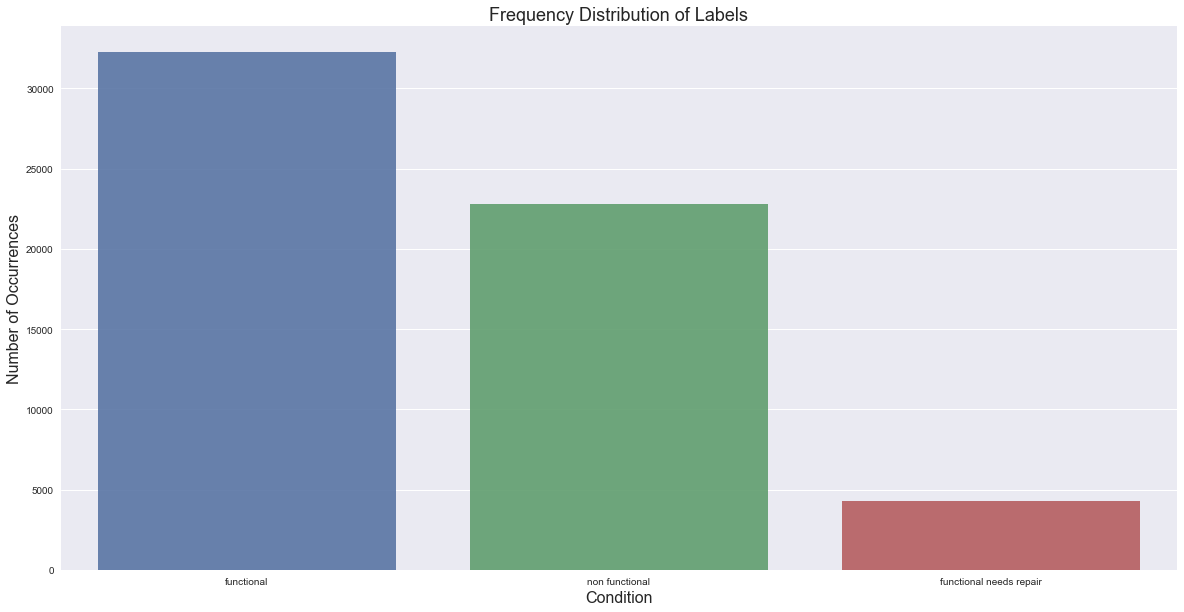

In [123]:
status_count = df['status_group'].value_counts()
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")
sns.barplot(status_count.index, status_count.values, alpha=0.9)
plt.title('Frequency Distribution of Labels', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Condition', fontsize=16)
plt.show()

#### An example of some of the procedures we took to analyze our feature set. After refactorization, we see that the majority of the funder belongs to "Other" and we can try to use one-hot encoding to present this feature.

No handles with labels found to put in legend.


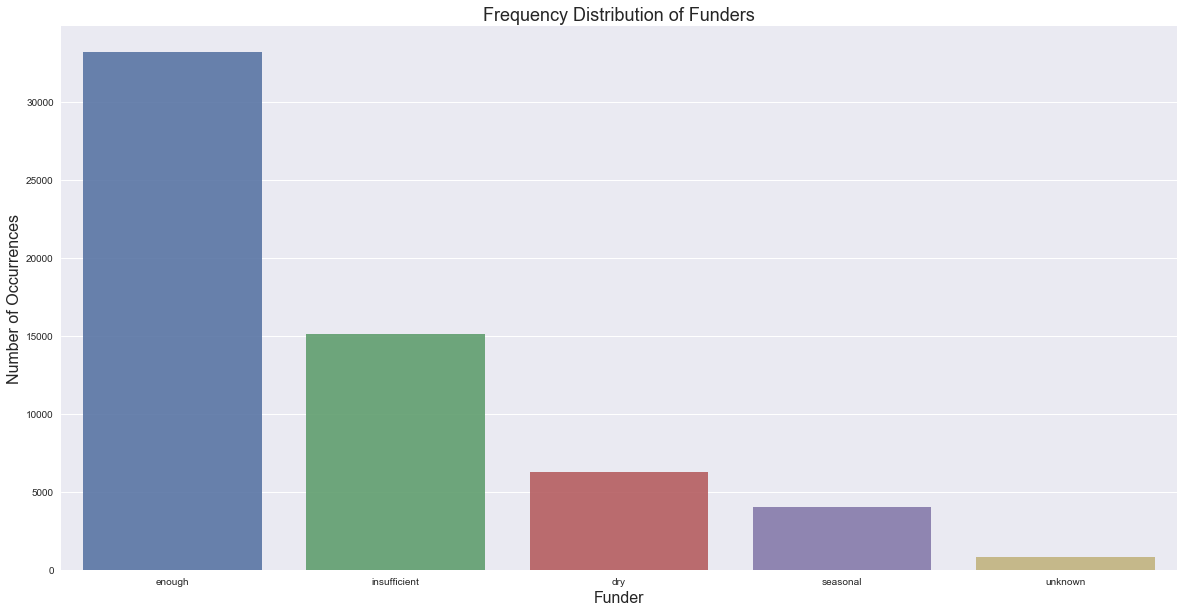

In [33]:
funder_count = df['quantity'].value_counts()
plt.figure(figsize=(20,10))
sns.set(style="darkgrid")
sns.barplot(funder_count.index, funder_count.values, alpha=0.9)
plt.title('Frequency Distribution of Funders', fontsize=18)
plt.ylabel('Number of Occurrences', fontsize=16)
plt.xlabel('Funder', fontsize=16)
plt.legend(fontsize=16)
plt.show()

In [37]:
df = df.drop(columns=[
#     'date_recorded', 
    'id',
    'lga',
    'ward',
    'num_private', # meaningless feature
    'region', # using region code
    'subvillage', # too many levels
    'quality_group', 
    'wpt_name', # too many levels, not related
    'quantity_group', # parent of water_quality
    'scheme_name', # not quite related
    'source_type', # parent of source
    'source_class', # parent of source_type
    'extraction_type_group',
    'extraction_type_class',
    'management_group',
    'payment_type', # repeating payment
    'waterpoint_type_group', # parent of waterpoint_type
    'recorded_by']) # not related to the condition

In [5]:
df_onehot = df.copy()

In [6]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
amount_tsh                   59400 non-null float64
funder                       59400 non-null object
gps_height                   59400 non-null int64
installer                    59400 non-null object
longitude                    59400 non-null float64
latitude                     59400 non-null float64
basin                        59400 non-null object
region_code                  59400 non-null int64
district_code                59400 non-null int64
population                   59400 non-null int64
public_meeting               59400 non-null object
scheme_management            55522 non-null object
permit                       56344 non-null object
construction_year            59400 non-null int64
extraction_type              59400 non-null object
management                   59400 non-null object
payment                      59400 non-null object
water_quality             

#### One-hot encoding the features we wanted to use

In [7]:
df_onehot = pd.get_dummies(df_onehot, columns=['funder',
                                               'installer',
                                               'basin',
                                               'public_meeting',
                                               'scheme_management',
                                               'permit',
                                               'extraction_type',
                                               'management',
                                               'payment',
                                               'water_quality',
                                               'quantity',
                                               'source',
                                               'waterpoint_type'])

lb_make = LabelEncoder()
df_onehot['status_group'] = lb_make.fit_transform(df_onehot['status_group'])

In [8]:
df_onehot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Columns: 121 entries, amount_tsh to waterpoint_type_other
dtypes: float64(3), int64(7), uint8(111)
memory usage: 10.8 MB


In [9]:
df_onehot.describe()

,amount_tsh,gps_height,longitude,latitude,region_code,district_code,population,construction_year,date_recorded_offset_days,status_group,...,source_shallow well,source_spring,source_unknown,waterpoint_type_cattle trough,waterpoint_type_communal standpipe,waterpoint_type_communal standpipe multiple,waterpoint_type_dam,waterpoint_type_hand pump,waterpoint_type_improved spring,waterpoint_type_other
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,...,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,15.297003,5.629747,179.909983,892.655471,642.616970,0.841162,...,0.283232,0.286549,0.001111,0.001953,0.480168,0.102744,0.000118,0.294411,0.013199,0.107407
std,2997.574558,693.116350,6.567432,2.946019e+00,17.587406,9.633649,471.482176,995.294508,334.216374,0.949794,...,0.450572,0.452153,0.033315,0.044148,0.499611,0.303627,0.010855,0.455781,0.114126,0.309633
min,0.000000,-90.000000,0.000000,-1.164944e+01,1.000000,0.000000,0.000000,0.000000,29.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,5.000000,2.000000,0.000000,0.000000,326.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,12.000000,3.000000,25.000000,0.000000,448.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,17.000000,5.000000,215.000000,2004.000000,1006.000000,2.000000,...,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,99.000000,80.000000,30500.000000,2012.000000,4097.000000,2.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


#### Direct factorization of categorical features into numeric features

In [38]:
values, unique = pd.factorize(df['funder'])
df['funder'] = values
values, unique = pd.factorize(df['installer'])
df['installer'] = values
values, unique = pd.factorize(df['basin'])
df['basin'] = values
values, unique = pd.factorize(df['public_meeting'])
df['public_meeting'] = values
values, unique = pd.factorize(df['scheme_management'])
df['scheme_management'] = values
values, unique = pd.factorize(df['permit'])
df['permit'] = values
values, unique = pd.factorize(df['extraction_type'])
df['extraction_type'] = values
values, unique = pd.factorize(df['management'])
df['management'] = values
values, unique = pd.factorize(df['payment'])
df['payment'] = values
values, unique = pd.factorize(df['water_quality'])
df['water_quality'] = values
values, unique = pd.factorize(df['quantity'])
df['quantity'] = values
values, unique = pd.factorize(df['source'])
df['source'] = values
values, unique = pd.factorize(df['waterpoint_type'])
df['waterpoint_type'] = values
values, unique = pd.factorize(df['status_group'])
df['status_group'] = values

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 23 columns):
amount_tsh                   59400 non-null float64
funder                       59400 non-null int64
gps_height                   59400 non-null int64
installer                    59400 non-null int64
longitude                    59400 non-null float64
latitude                     59400 non-null float64
basin                        59400 non-null int64
region_code                  59400 non-null int64
district_code                59400 non-null int64
population                   59400 non-null int64
public_meeting               59400 non-null int64
scheme_management            59400 non-null int64
permit                       59400 non-null int64
construction_year            59400 non-null int64
extraction_type              59400 non-null int64
management                   59400 non-null int64
payment                      59400 non-null int64
water_quality                59400 

In [8]:
df.head(20)

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region_code,district_code,population,...,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,date_recorded_offset_days,status_group
0,6000.0,0,1390,0,34.938093,-9.856322,0,11,5,109,...,1999,0,0,0,0,0,0,0,1024,0
1,0.0,0,1399,0,34.698766,-2.147466,1,20,2,280,...,2010,0,1,1,0,1,1,0,301,0
2,25.0,0,686,0,37.460664,-3.821329,2,21,4,250,...,2009,0,0,2,0,0,2,1,310,0
3,0.0,1,263,0,38.486161,-11.155298,3,90,63,58,...,0,1,0,1,0,2,3,1,338,1
4,0.0,0,0,0,31.130847,-1.825359,1,18,1,0,...,0,0,2,1,0,3,1,0,903,0
5,20.0,0,0,1,39.172796,-4.765587,2,4,8,1,...,2009,1,0,2,1,0,4,1,1025,0
6,0.0,0,0,0,33.362410,-3.766365,4,17,3,0,...,0,2,0,1,0,0,3,2,457,1
7,0.0,2,0,1,32.620617,-4.226198,5,17,3,0,...,0,3,1,3,2,0,5,2,449,1
8,0.0,0,0,0,32.711100,-5.146712,5,14,6,0,...,0,4,0,1,1,3,3,2,424,1
9,0.0,0,0,0,30.626991,-1.257051,1,18,1,0,...,0,3,0,1,0,0,5,2,882,0


In [9]:
df.describe()

,amount_tsh,funder,gps_height,installer,longitude,latitude,basin,region_code,district_code,population,...,construction_year,extraction_type,management,payment,water_quality,quantity,source,waterpoint_type,date_recorded_offset_days,status_group
count,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,...,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,1.882340,668.297239,1.012912,34.077427,-5.706033e+00,3.641296,15.297003,5.629747,179.909983,...,892.655471,2.284276,1.178485,2.331902,0.294529,0.722677,3.237441,1.077054,642.616970,0.529596
std,2997.574558,2.766412,693.116350,1.895514,6.567432,2.946019e+00,2.419185,17.587406,9.633649,471.482176,...,995.294508,2.800023,2.256039,1.832529,0.901654,0.989555,2.424562,1.162443,334.216374,0.628080
min,0.000000,0.000000,-90.000000,0.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,33.090347,-8.540621e+00,1.000000,5.000000,2.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,326.000000,0.000000
50%,0.000000,0.000000,369.000000,0.000000,34.908743,-5.021597e+00,4.000000,12.000000,3.000000,25.000000,...,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,3.000000,1.000000,448.000000,0.000000
75%,20.000000,4.000000,1319.250000,1.000000,37.178387,-3.326156e+00,6.000000,17.000000,5.000000,215.000000,...,2004.000000,4.000000,1.000000,3.000000,0.000000,1.000000,5.000000,2.000000,1006.000000,1.000000
max,350000.000000,9.000000,2770.000000,9.000000,40.345193,-2.000000e-08,8.000000,99.000000,80.000000,30500.000000,...,2012.000000,16.000000,11.000000,6.000000,7.000000,4.000000,9.000000,6.000000,4097.000000,2.000000


In [10]:
df.corr().abs()['status_group'].sort_values(ascending=False)

status_group                 1.000000
quantity                     0.188637
construction_year            0.137067
waterpoint_type              0.114303
gps_height                   0.096408
funder                       0.095888
region_code                  0.083590
water_quality                0.075322
source                       0.072154
longitude                    0.071635
installer                    0.065130
extraction_type              0.062121
public_meeting               0.061128
payment                      0.049249
management                   0.048152
date_recorded_offset_days    0.045972
amount_tsh                   0.043533
district_code                0.033979
permit                       0.028971
scheme_management            0.028835
latitude                     0.021020
population                   0.015198
basin                        0.009175
Name: status_group, dtype: float64

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: T

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not use

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: Use

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a mask

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1481: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: Use

/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'label', 'color'
  s)
/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1480: UserWarning: Warning: converting a masked ele

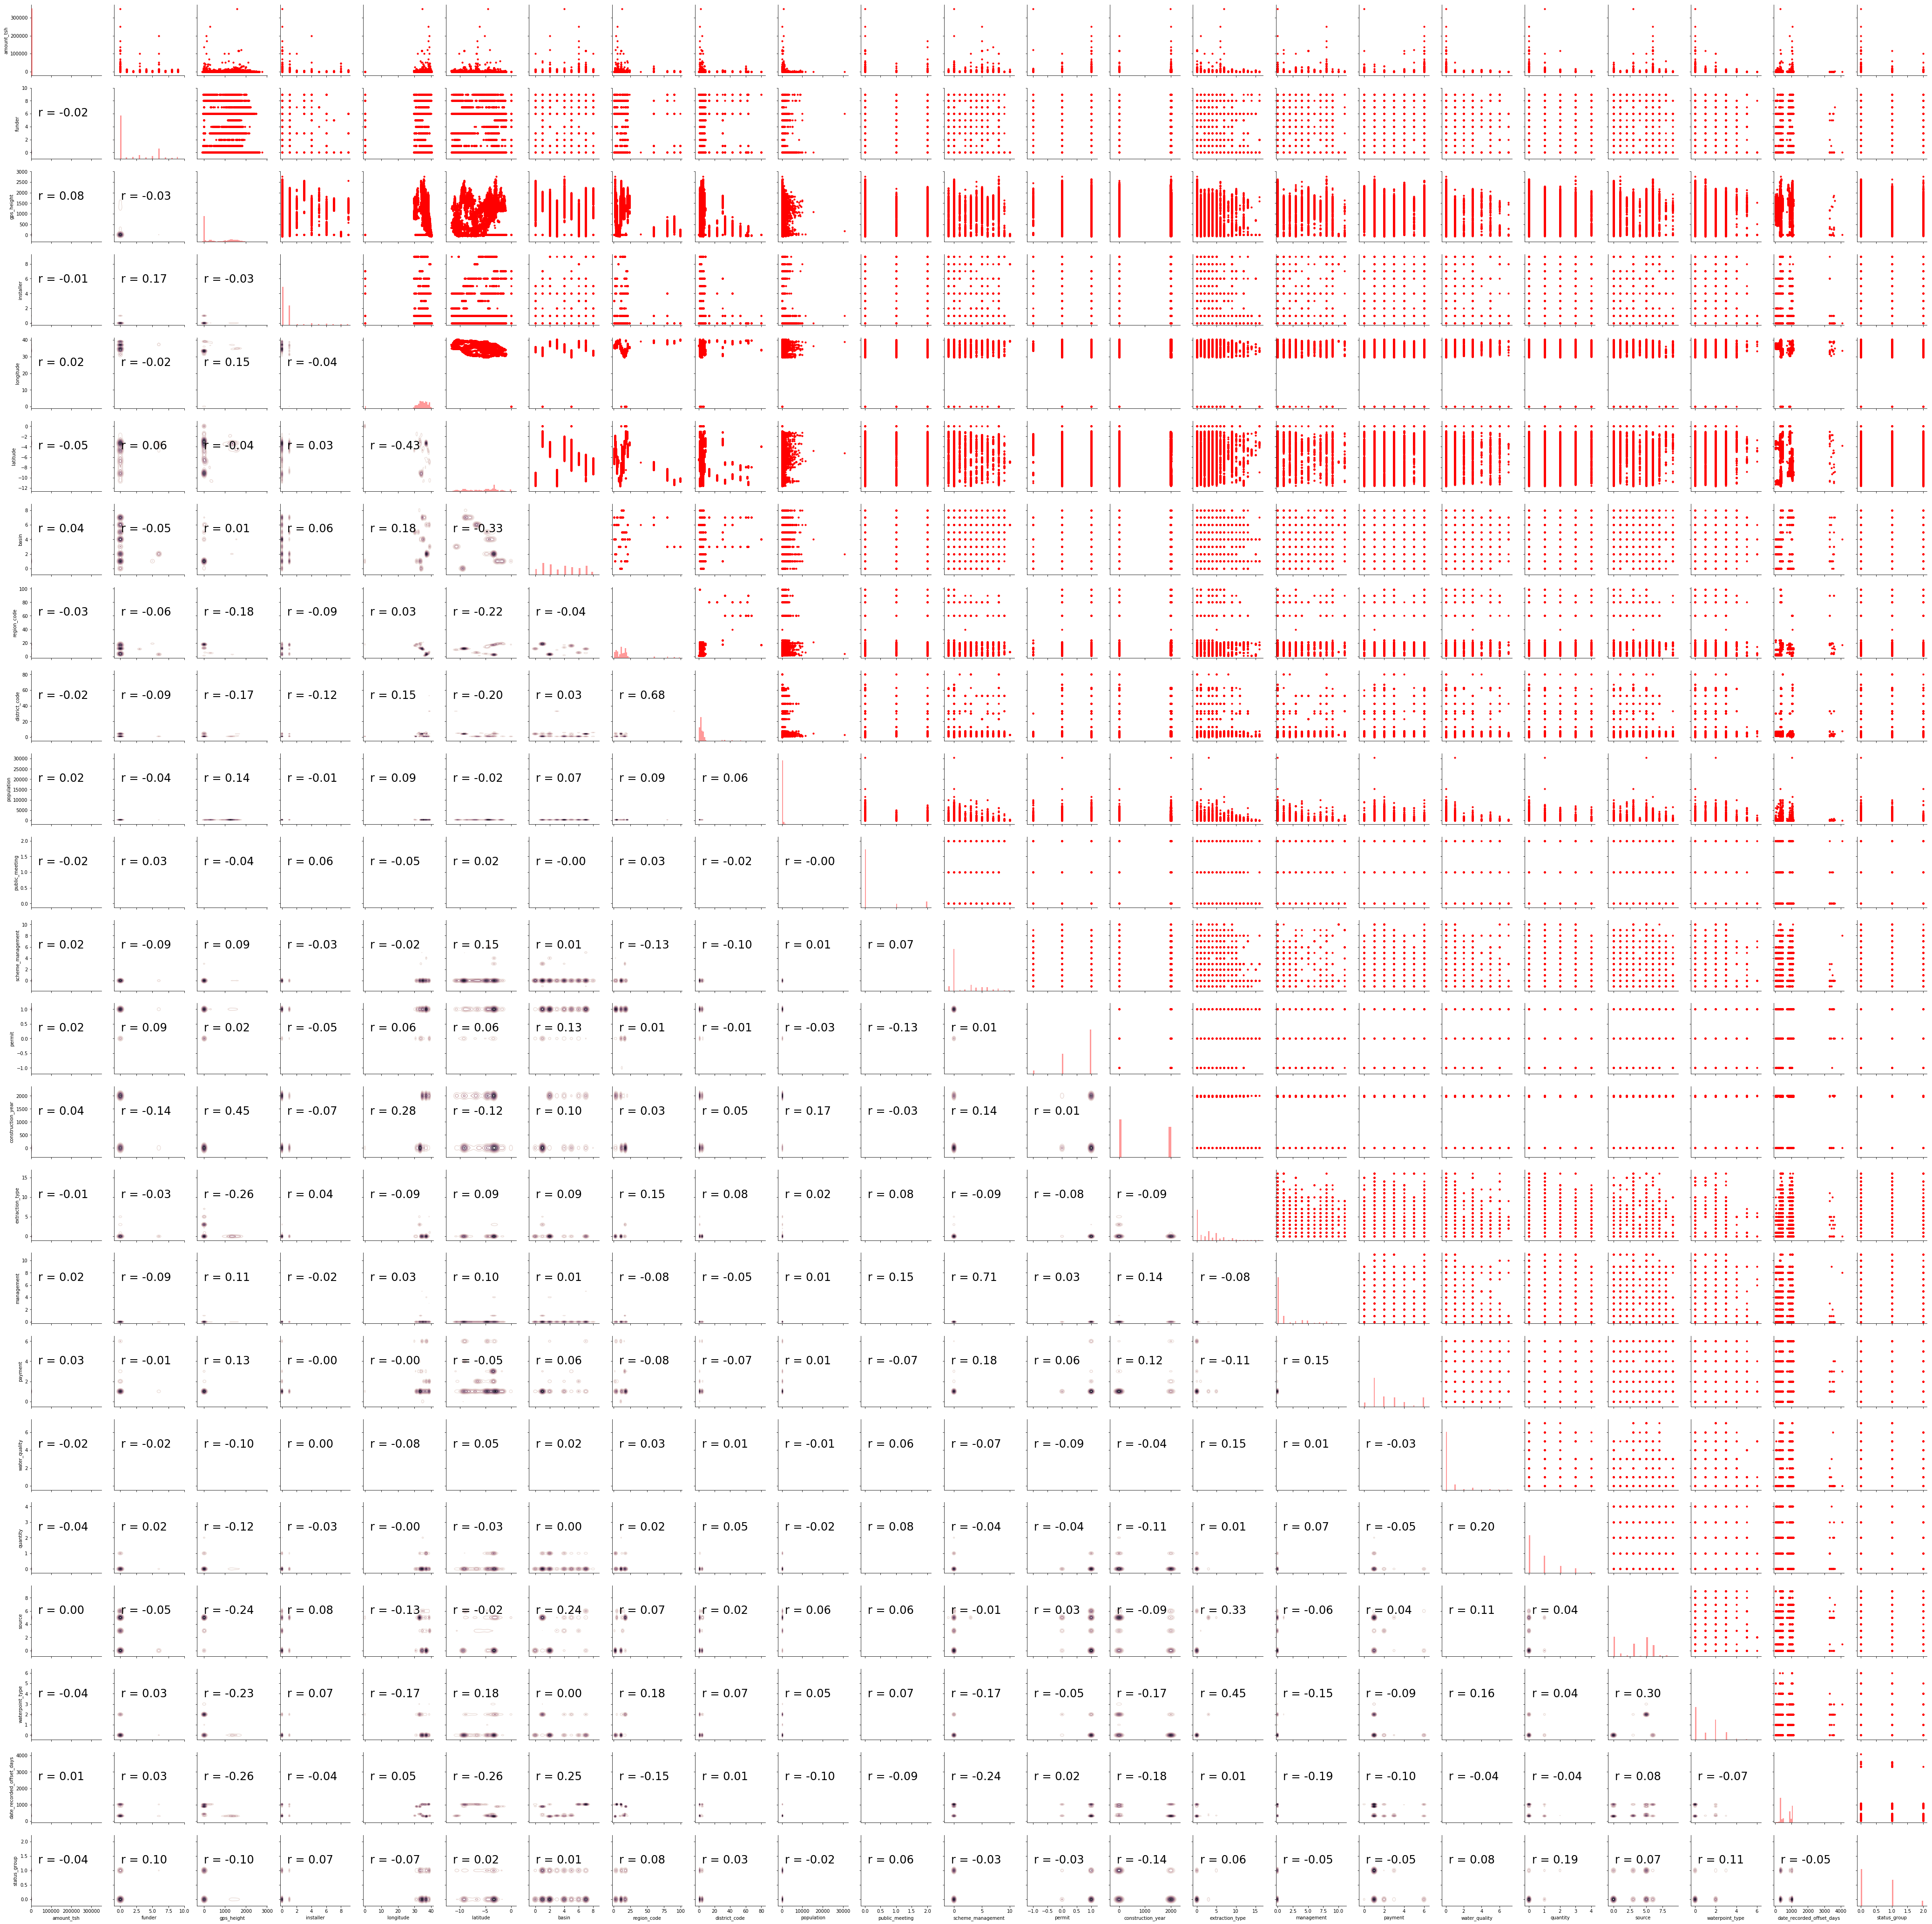

In [67]:
X = df[df.columns.difference(['status_group'])].values
y = df['status_group'].values
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.1, .6), xycoords=ax.transAxes,
               size = 24)
    
cmap = sns.cubehelix_palette(light=1, dark = 0.1,
                             hue = 0.5, as_cmap=True)

sns.set_context(font_scale=2)

# Pair grid set up
g = sns.PairGrid(df)

# Scatter plot on the upper triangle
g.map_upper(plt.scatter, s=10, color = 'red')

# Distribution on the diagonal
g.map_diag(sns.distplot, kde=False, color = 'red')

# Density Plot and Correlation coefficients on the lower triangle
g.map_lower(sns.kdeplot, cmap = cmap)
g.map_lower(corrfunc);

## Evaluation on KNN-model

In [40]:
X = df[df.columns.difference(['status_group'])].values
y = df['status_group'].values

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)

X_train = scale(X_train)
X_test = scale(X_test)

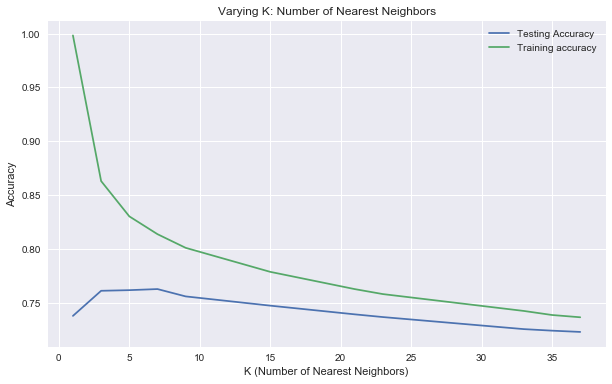

In [119]:
# Set the the range of K 
neighbors = [1, 3, 5, 7, 9, 15, 21, 23, 33, 35, 37]
# Two arrays to store training and test accuracies
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

for i,k in enumerate(neighbors):
    
    # Setup a knn classifier with k neighbors
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fit the model
    knn.fit(X_train, y_train)
    
    
    # The "score" function returns the mean accuracy on the given train/test data and labels.
    # Note that "accuracy" may not be a good performance measure in a skewed data set
    # Thus, we need to do hyperparameter tuning by using better performance measures (e.g., f1 score, presision, recall)
    
    # Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)
    
    # Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test) 

fig = plt.figure(figsize=(10, 6))
plt.title('Varying K: Number of Nearest Neighbors')
plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('K (Number of Nearest Neighbors)')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
param_grid = {'n_neighbors': [15, 21, 23, 33, 35, 37],
             'p': [1, 2, 10],
             'weights': ["uniform", "distance"],
             'algorithm': ['ball_tree']}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, param_grid, scoring='f1_micro', cv=10)
knn_cv.fit(X_train, y_train)

print("Best Score: %f" % knn_cv.best_score_)
print("Optimal Hyperparameter Values: ", knn_cv.best_params_)

In [43]:
%%time
knn = KNeighborsClassifier(weights='distance', algorithm='ball_tree', n_neighbors=5)
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_train, y_train, scoring='f1_macro', cv=10)
print(scores)

y_train_pred = cross_val_predict(knn, X_train, y_train, cv=10)

cm = confusion_matrix(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='micro') 
recall = recall_score(y_train, y_train_pred, average='micro')
f1 = f1_score(y_train, y_train_pred, average='micro')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Confusion Matrix:")
print(str(cm))
print("Precision = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f1)

[0.66618853 0.64847691 0.66077063 0.66021812 0.65285359 0.65920814
 0.64556804 0.6573016  0.65242475 0.64513401]
Accuracy: 0.65 (+/- 0.01)
Confusion Matrix:
[[21493  3283  1026]
 [ 4086 13675   491]
 [ 1634   623  1209]]
Precision = 0.765509
Recall = 0.765509
F1 Score = 0.765509
CPU times: user 4min 42s, sys: 1.04 s, total: 4min 43s
Wall time: 4min 45s


In [109]:
X = df_onehot[df_onehot.columns.difference(['status_group'])].values
y = df_onehot['status_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=42)
X_train = scale(X_train)
X_test = scale(X_test)
knn = KNeighborsClassifier(weights='distance', algorithm='auto', n_neighbors=23, p=1)
knn.fit(X_train, y_train)

scores = cross_val_score(knn, X_train, y_train, scoring='f1_macro', cv=10)
print(scores)

y_train_pred = cross_val_predict(knn, X_train, y_train, cv=10)

cm = confusion_matrix(y_train, y_train_pred)
precision = precision_score(y_train, y_train_pred, average='micro') 
recall = recall_score(y_train, y_train_pred, average='micro')
f1 = f1_score(y_train, y_train_pred, average='micro')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Confusion Matrix:")
print(str(cm))
print("Precision = %f" % precision)
print("Recall = %f" % recall)
print("F1 Score = %f" % f1)

[0.6694486  0.66583033 0.6755502  0.68348915 0.66009074 0.66722238
 0.66072054 0.66392532 0.66957605 0.65865702]
Accuracy: 0.67 (+/- 0.01)
Confusion Matrix:
[[22499   787  2516]
 [ 1772  1146   548]
 [ 4340   357 13555]]
Precision = 0.782828
Recall = 0.782828
F1 Score = 0.782828


## Evaluation on Softmax Regression 

In [29]:
%run model.ipynb

In [30]:
X = df[df.columns.difference(['status_group'])].values
Y = df['status_group'].values

In [31]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state=42)

In [32]:
softmax_reg = Softmax_Regression()
softmax_reg.fit(X_train, Y_train, learning_rate=0.1, lambd=0.0001, tol=0.0001, regularizer='l2')
y_test_pred = softmax_reg.predict(X_test)
# print("Accuracy of test data: %.4f" % accuracy(y_test_pred, Y_test))
accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))
print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in multiply



Accuracy:  0.5653198653198653

Test Confusion Matrix:
[[5118 1339    0]
 [2974 1598    0]
 [ 626  225    0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.59      0.79      0.67      6457
          1       0.51      0.35      0.41      4572
          2       0.00      0.00      0.00       851

avg / total       0.51      0.57      0.53     11880



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Multiclass Logistic Regression (sklearn)

In [14]:
X = df[df.columns.difference(['status_group'])].values
y = df['status_group'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [19]:
lg_reg_clf = LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

lg_reg_clf.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [20]:
print("No. of Iterations:",lg_reg_clf.n_iter_ )
y_test_predicted = lg_reg_clf.predict(X_test)
#print(y_test_predict)
accuracy_score_test = np.mean(y_test_predicted == y_test)
print("\nAccuracy: ", accuracy_score_test)
print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))
print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

No. of Iterations: [8293]

Accuracy:  0.5653198653198653

Test Confusion Matrix:
[[5118 1339    0]
 [2974 1598    0]
 [ 626  225    0]]

Classification Report:
             precision    recall  f1-score   support

          0       0.59      0.79      0.67      6457
          1       0.51      0.35      0.41      4572
          2       0.00      0.00      0.00       851

avg / total       0.51      0.57      0.53     11880



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Random Forest

In [43]:
X = df[df.columns.difference(['status_group'])].values
y = df['status_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [44]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=2, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [45]:
print(clf.feature_importances_)

[0.12853281 0.00102252 0.10133624 0.00162265 0.00332494 0.16378165
 0.01945773 0.02340548 0.00231023 0.00245847 0.02256456 0.02192822
 0.02936185 0.         0.00360572 0.00100602 0.26076737 0.00832684
 0.00354086 0.01155659 0.01336488 0.17672436]


In [46]:
y_test_pred = clf.predict(X_test)
print("Training Accuracy: ", clf.score(X_train, y_train))
print("Test Accuracy: ", clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision_test = precision_score(y_test, y_test_pred, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_pred, average='micro')
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_pred, average='micro')
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Training Accuracy:  0.6789772727272727
Test Accuracy:  0.6783670033670034

Test Confusion Matrix:
[[5118 1339    0]
 [2974 1598    0]
 [ 626  225    0]]

Test Precision = 0.565320
Test Recall = 0.565320
Test F1 Score = 0.565320

Classification Report:
             precision    recall  f1-score   support

          0       0.59      0.79      0.67      6457
          1       0.51      0.35      0.41      4572
          2       0.00      0.00      0.00       851

avg / total       0.51      0.57      0.53     11880



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [38]:
%%time

param_grid = {'n_estimators': [1, 10, 50, 100, 200],
              'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth': [1, 4, 8, 16, 32],
              'min_samples_split': [0.1, 0.4, 0.8, 1.0],
              'min_samples_leaf': [0.1, 0.3, 0.5]}

clf = RandomForestClassifier()

clf_cv = GridSearchCV(clf, param_grid, scoring='accuracy', cv=5)
clf_cv.fit(X_train, y_train)

params_optimal = clf_cv.best_params_

print("Best Score (accuracy): %f" % clf_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)
print("\n")

Best Score (accuracy): 0.661427
Optimal Hyperparameter Values:  {'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 50}


CPU times: user 37min 33s, sys: 15.2 s, total: 37min 48s
Wall time: 37min 50s


In [50]:
clf = RandomForestClassifier(n_estimators=50, max_depth=4, random_state=42, max_features='sqrt', 
                            min_samples_leaf=0.1, min_samples_split=0.1)
clf.fit(X_train, y_train)
print(clf.feature_importances_)
y_test_pred = clf.predict(X_test)
print("Training Accuracy: ", clf.score(X_train, y_train))
print("Test Accuracy: ", clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision_test = precision_score(y_test, y_test_pred, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_pred, average='micro')
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_pred, average='micro')
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

[0.14099388 0.00233182 0.10273141 0.00434139 0.00057128 0.24606264
 0.01340469 0.03525294 0.00095374 0.01112872 0.03004134 0.01663158
 0.01972331 0.         0.01282447 0.         0.26971114 0.01222407
 0.0059592  0.01547123 0.         0.05964115]
Training Accuracy:  0.6642676767676767
Test Accuracy:  0.6627104377104377

Test Confusion Matrix:
[[5733  724    0]
 [2432 2140    0]
 [ 748  103    0]]

Test Precision = 0.662710
Test Recall = 0.662710
Test F1 Score = 0.662710

Classification Report:
             precision    recall  f1-score   support

          0       0.64      0.89      0.75      6457
          1       0.72      0.47      0.57      4572
          2       0.00      0.00      0.00       851

avg / total       0.63      0.66      0.62     11880



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [20]:
df_dummy = pd.read_csv("./myTrainDummy.csv")
lb_make = LabelEncoder()
df_dummy['status_group'] = lb_make.fit_transform(df_dummy['status_group'])

In [28]:
X = pd.read_csv("./myTrainDummy.csv")
labels = pd.read_csv("./training_set_labels.csv")
y = labels['status_group']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
clf = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=0, max_features='sqrt', 
                            min_samples_leaf=0.1, min_samples_split=0.1)
clf.fit(X_train, y_train)
# print(clf.feature_importances_)
y_test_pred = clf.predict(X_test)
print("Training Accuracy: ", clf.score(X_train, y_train))
print("Test Accuracy: ", clf.score(X_test, y_test))

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_pred))

precision_test = precision_score(y_test, y_test_pred, average='micro') 
print("\nTest Precision = %f" % precision_test)

recall_test = recall_score(y_test, y_test_pred, average='micro')
print("Test Recall = %f" % recall_test)

f1_test = f1_score(y_test, y_test_pred, average='micro')
print("Test F1 Score = %f" % f1_test)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

Training Accuracy:  0.5800084175084175
Test Accuracy:  0.5820707070707071

Test Confusion Matrix:
[[6433    0   24]
 [ 843    0    8]
 [4090    0  482]]

Test Precision = 0.582071
Test Recall = 0.582071
Test F1 Score = 0.582071

Classification Report:
                         precision    recall  f1-score   support

             functional       0.57      1.00      0.72      6457
functional needs repair       0.00      0.00      0.00       851
         non functional       0.94      0.11      0.19      4572

            avg / total       0.67      0.58      0.47     11880



/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Linear Regression (Not chosen but for comparison with logistic regression)

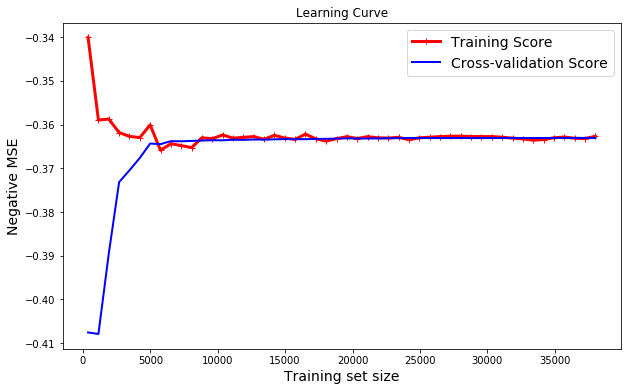

In [49]:
train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50),
                                                        n_jobs=-1)
                                                

# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve")
plt.show()

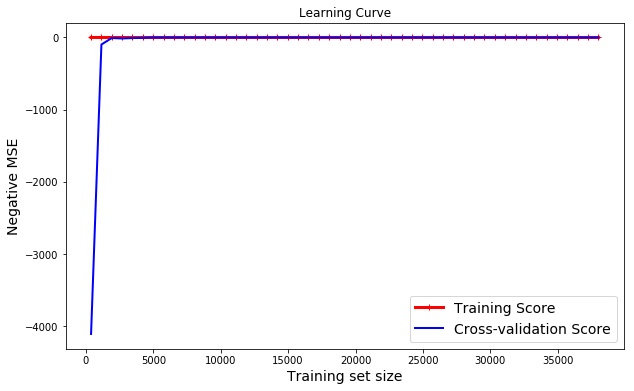

In [54]:
poly_degree = 2

poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

scaler = StandardScaler().fit(X_train_poly)
X_train_poly_standardized = scaler.transform(X_train_poly)

train_sizes, train_scores, val_scores = learning_curve(LinearRegression(), X_train_poly_standardized, y_train, cv=5, 
                                                        scoring='neg_mean_squared_error', 
                                                        train_sizes=np.linspace(0.01, 1.0, 50))
                                                        
# Create means and standard deviations of training set scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)

# Create means and standard deviations of validation set scores
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, "r-+", linewidth=3, label="Training Score")
plt.plot(train_sizes, val_mean, "b-", linewidth=2, label="Cross-validation Score")
plt.legend(loc="best", fontsize=14)   
plt.xlabel("Training set size", fontsize=14) 
plt.ylabel("Negative MSE", fontsize=14) 
plt.title("Learning Curve")

plt.show()

In [59]:
X = df[df.columns.difference(['status_group'])].values
y = df['status_group'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
poly_degree = 2

# Add polynomial terms with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train)

print(X_train_poly.shape)

lin_reg_poly = LinearRegression()

lin_reg_poly.fit(X_train_poly, y_train)

print("\n----------------------------- Model Evaluation -----------------------------")
y_train_poly_predicted = lin_reg_poly.predict(X_train_poly)
print("\nMean squared error: %.2f"
      % mean_squared_error(y_train, y_train_poly_predicted))
print("Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f" % r2_score(y_train, y_train_poly_predicted))

(47520, 275)

----------------------------- Model Evaluation -----------------------------

Mean squared error: 0.33
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.18


In [60]:
poly_degree = 2

# Add polynomial and bias term with the feature vector using the sklearn PolynomialFeatures class
poly_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
X_test_poly = poly_features.fit_transform(X_test)

print(X_test_poly.shape)
print("\n----------------------------- Model Evaluation -----------------------------")
y_test_poly_predicted = lin_reg_poly.predict(X_test_poly)
print("\nMean squared error: %.2f"
      % mean_squared_error(y_test, y_test_poly_predicted))
print('Coefficient of determination r^2 variance score [1 is perfect prediction]: %.2f' % r2_score(y_test, y_test_poly_predicted))

(11880, 275)

----------------------------- Model Evaluation -----------------------------

Mean squared error: 0.33
Coefficient of determination r^2 variance score [1 is perfect prediction]: 0.16
